In [684]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
def set_all_seeds(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
set_all_seeds(142)

<Axes: title={'center': 'Closing Price of Asset'}>

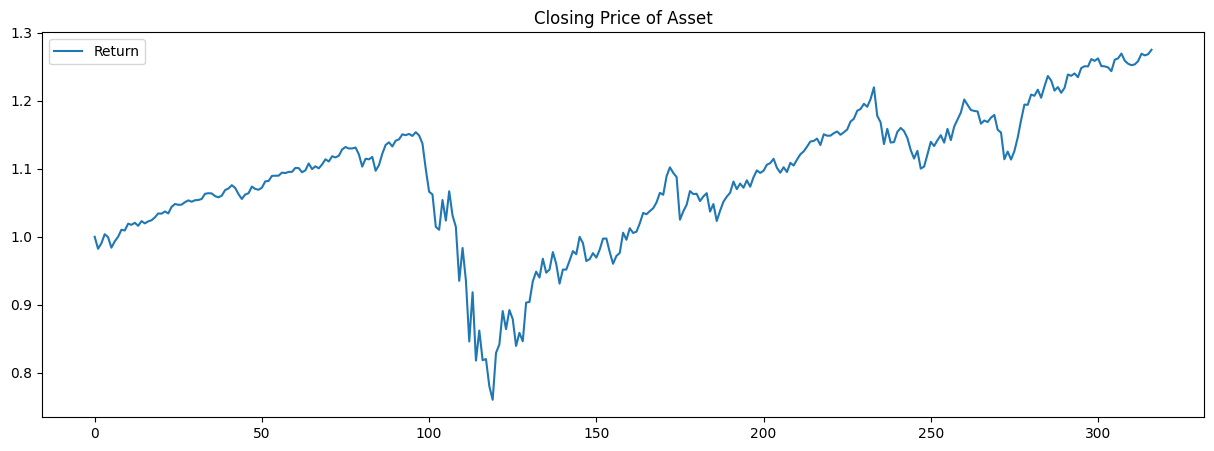

In [685]:
ticker = "SPY"

# history : 2019-10-01 ~ 2022-01-01 的数据
history = pd.read_csv(f'D:\Research\DLinear\data\{ticker}.csv')
history['date'] = pd.to_datetime(history['date'])

start_date = '2019-10-01'
end_date = '2021-01-01'

# data : Warming Up 期间的数据
data = history[(history['date'] >= start_date) 
               & (history['date'] <= end_date)]
df = data[["Return"]]
df.plot(figsize=(15,5), title="Closing Price of Asset")

In [686]:
df = df.reset_index(drop=True)

<Axes: title={'center': 'Daily percentage change (Daily Return)'}>

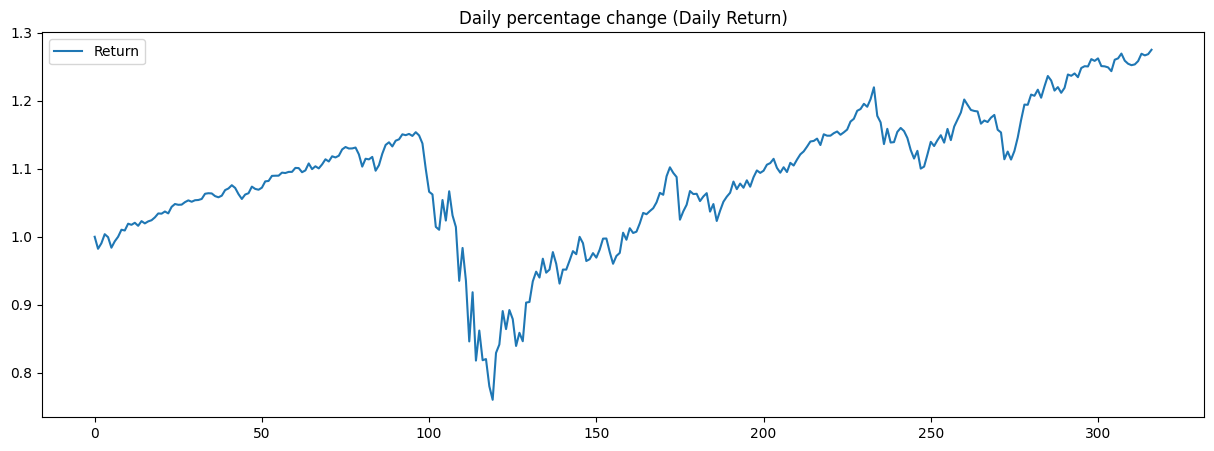

In [687]:
df.plot(figsize=(15,5), title = 'Daily percentage change (Daily Return)')

In [688]:
df_norm = df.to_numpy()

In [689]:
class Dataset_Custom(Dataset):
    def __init__(self, df, seq_len, pred_len):
        self.df = df
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __getitem__(self, index):
        # input
        input_begin = index
        input_end = input_begin + self.seq_len

        # label
        label_begin = input_end
        label_end = label_begin + self.pred_len

        seq_x = self.df[input_begin:input_end]
        seq_y = self.df[label_begin:label_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

In [690]:
# DLinear模型
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class DLinear(nn.Module):
    """
    Decomposition-Linear
    """
    def __init__(self, seq_len, pred_len, kernel_size):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)

        self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
        
        # Use this two lines if you want to visualize the weights
        # self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        # self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
 
        seasonal_output = self.Linear_Seasonal(seasonal_init)

        trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

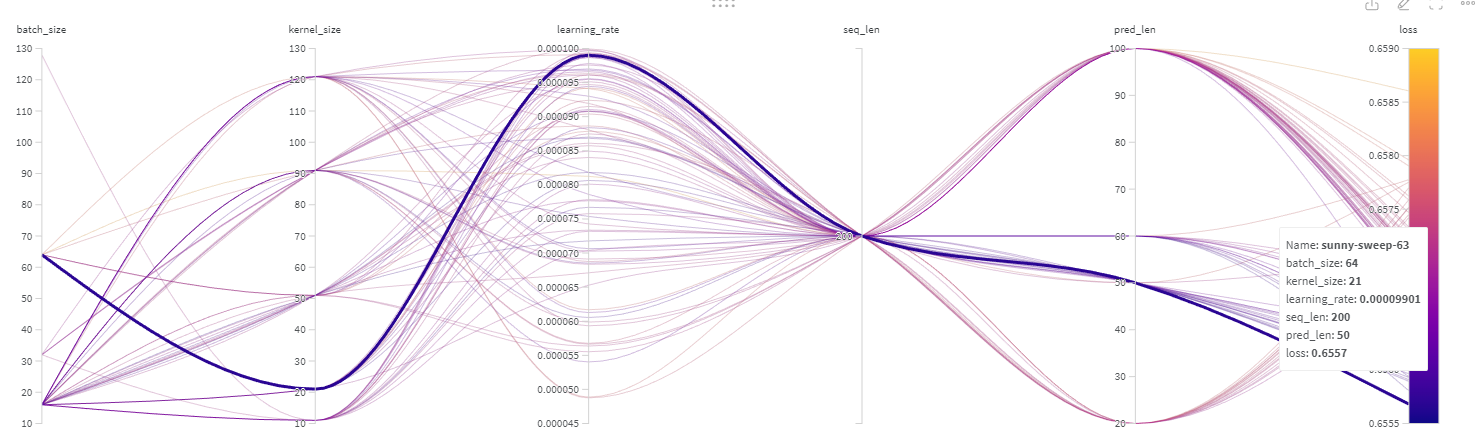

In [691]:
num_epoch = 200
config = dict(
    batch_size= 64,
    kernel_size= 21,
    learning_rate= 0.0001,
    seq_len= 24,
    pred_len= 24,
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_set = Dataset_Custom(
        df=df_norm,
        seq_len=config['seq_len'],
        pred_len=config['pred_len']
        )

data_loader = DataLoader(
        data_set,
        batch_size=config['batch_size'],
        shuffle=True,
        drop_last=False)

model = DLinear(seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                kernel_size=config['kernel_size']
                ).to(device)

from tqdm import tqdm
from torchmetrics import MeanAbsolutePercentageError

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.L1Loss().to(device)

train_loss_ep = []
for epoch in tqdm(range(num_epoch)):
    train_loss = []

    model.train()
    for i, (batch_x, batch_y) in enumerate(data_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        outputs = model(batch_x)


        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #log
        train_loss.append(loss.item())

    train_loss_ep.append(np.average(train_loss))

    print(f"Epoch: {epoch+1}/{num_epoch}, Training Loss: {np.average(train_loss)}")

  5%|▌         | 10/200 [00:00<00:02, 94.65it/s]

Epoch: 1/200, Training Loss: 1.028270697593689
Epoch: 2/200, Training Loss: 1.013397252559662
Epoch: 3/200, Training Loss: 0.9987655758857727
Epoch: 4/200, Training Loss: 0.9953367829322814
Epoch: 5/200, Training Loss: 0.976001524925232
Epoch: 6/200, Training Loss: 0.9673555850982666
Epoch: 7/200, Training Loss: 0.9493135929107666
Epoch: 8/200, Training Loss: 0.9364686012268066
Epoch: 9/200, Training Loss: 0.9251272797584533
Epoch: 10/200, Training Loss: 0.9144829511642456
Epoch: 11/200, Training Loss: 0.8951638102531433
Epoch: 12/200, Training Loss: 0.8818506717681884
Epoch: 13/200, Training Loss: 0.8698434114456177
Epoch: 14/200, Training Loss: 0.8604673027992249
Epoch: 15/200, Training Loss: 0.8474897146224976
Epoch: 16/200, Training Loss: 0.8376010656356812
Epoch: 17/200, Training Loss: 0.8174149394035339
Epoch: 18/200, Training Loss: 0.8080115795135498


 14%|█▍        | 29/200 [00:00<00:01, 86.67it/s]

Epoch: 19/200, Training Loss: 0.794858169555664
Epoch: 20/200, Training Loss: 0.7822145700454712
Epoch: 21/200, Training Loss: 0.7759958624839782
Epoch: 22/200, Training Loss: 0.7601965308189392
Epoch: 23/200, Training Loss: 0.7452371478080749
Epoch: 24/200, Training Loss: 0.7381155014038085
Epoch: 25/200, Training Loss: 0.7229753375053406
Epoch: 26/200, Training Loss: 0.7082627296447754
Epoch: 27/200, Training Loss: 0.6949091672897338
Epoch: 28/200, Training Loss: 0.6847439289093018
Epoch: 29/200, Training Loss: 0.676145076751709
Epoch: 30/200, Training Loss: 0.65808664560318
Epoch: 31/200, Training Loss: 0.6507173776626587
Epoch: 32/200, Training Loss: 0.6404470324516296
Epoch: 33/200, Training Loss: 0.6243675708770752
Epoch: 34/200, Training Loss: 0.6092165589332581
Epoch: 35/200, Training Loss: 0.6011947274208069
Epoch: 36/200, Training Loss: 0.5892426013946533
Epoch: 37/200, Training Loss: 0.5780725479125977


 26%|██▌       | 52/200 [00:00<00:01, 100.86it/s]

Epoch: 38/200, Training Loss: 0.5627894520759582
Epoch: 39/200, Training Loss: 0.5574511885643005
Epoch: 40/200, Training Loss: 0.5462306380271912
Epoch: 41/200, Training Loss: 0.5359304070472717
Epoch: 42/200, Training Loss: 0.5285417437553406
Epoch: 43/200, Training Loss: 0.5151294708251953
Epoch: 44/200, Training Loss: 0.5065410435199738
Epoch: 45/200, Training Loss: 0.4922017097473145
Epoch: 46/200, Training Loss: 0.48476672172546387
Epoch: 47/200, Training Loss: 0.4769415080547333
Epoch: 48/200, Training Loss: 0.4643228888511658
Epoch: 49/200, Training Loss: 0.45449676513671877
Epoch: 50/200, Training Loss: 0.4468264579772949
Epoch: 51/200, Training Loss: 0.4366095721721649
Epoch: 52/200, Training Loss: 0.42651026844978335
Epoch: 53/200, Training Loss: 0.418124383687973
Epoch: 54/200, Training Loss: 0.4080664575099945
Epoch: 55/200, Training Loss: 0.4021031141281128
Epoch: 56/200, Training Loss: 0.3921793162822723
Epoch: 57/200, Training Loss: 0.3853748857975006
Epoch: 58/200, Tra

 41%|████      | 82/200 [00:00<00:00, 124.65it/s]

Epoch: 64/200, Training Loss: 0.3331056535243988
Epoch: 65/200, Training Loss: 0.3250356137752533
Epoch: 66/200, Training Loss: 0.31927943229675293
Epoch: 67/200, Training Loss: 0.31298614740371705
Epoch: 68/200, Training Loss: 0.305626654624939
Epoch: 69/200, Training Loss: 0.2994516670703888
Epoch: 70/200, Training Loss: 0.2943906605243683
Epoch: 71/200, Training Loss: 0.288243705034256
Epoch: 72/200, Training Loss: 0.2821872651576996
Epoch: 73/200, Training Loss: 0.27463836669921876
Epoch: 74/200, Training Loss: 0.27014081478118895
Epoch: 75/200, Training Loss: 0.2655501663684845
Epoch: 76/200, Training Loss: 0.2579307943582535
Epoch: 77/200, Training Loss: 0.254834920167923
Epoch: 78/200, Training Loss: 0.24694387912750243
Epoch: 79/200, Training Loss: 0.24381483495235443
Epoch: 80/200, Training Loss: 0.2387446492910385
Epoch: 81/200, Training Loss: 0.23420937359333038
Epoch: 82/200, Training Loss: 0.22862957417964935
Epoch: 83/200, Training Loss: 0.22322685718536378
Epoch: 84/200,

 57%|█████▋    | 114/200 [00:00<00:00, 139.49it/s]

Epoch: 95/200, Training Loss: 0.17621950507164003
Epoch: 96/200, Training Loss: 0.17255940437316894
Epoch: 97/200, Training Loss: 0.17174974977970123
Epoch: 98/200, Training Loss: 0.1645171046257019
Epoch: 99/200, Training Loss: 0.16471362113952637
Epoch: 100/200, Training Loss: 0.15949619114398955
Epoch: 101/200, Training Loss: 0.1573878049850464
Epoch: 102/200, Training Loss: 0.1533640593290329
Epoch: 103/200, Training Loss: 0.14777929484844207
Epoch: 104/200, Training Loss: 0.14505608677864074
Epoch: 105/200, Training Loss: 0.14453238546848296
Epoch: 106/200, Training Loss: 0.14042187631130218
Epoch: 107/200, Training Loss: 0.13641667664051055
Epoch: 108/200, Training Loss: 0.13511870205402374
Epoch: 109/200, Training Loss: 0.13313164412975312
Epoch: 110/200, Training Loss: 0.1307911306619644
Epoch: 111/200, Training Loss: 0.12649705857038498
Epoch: 112/200, Training Loss: 0.12528980970382692
Epoch: 113/200, Training Loss: 0.12230336219072342
Epoch: 114/200, Training Loss: 0.1220238

 72%|███████▎  | 145/200 [00:01<00:00, 144.96it/s]

Epoch: 125/200, Training Loss: 0.10131293833255768
Epoch: 126/200, Training Loss: 0.1035506010055542
Epoch: 127/200, Training Loss: 0.09608872085809708
Epoch: 128/200, Training Loss: 0.09731199890375138
Epoch: 129/200, Training Loss: 0.0934261441230774
Epoch: 130/200, Training Loss: 0.09139682650566101
Epoch: 131/200, Training Loss: 0.09285912960767746
Epoch: 132/200, Training Loss: 0.09028318822383881
Epoch: 133/200, Training Loss: 0.08786927610635757
Epoch: 134/200, Training Loss: 0.08884298652410508
Epoch: 135/200, Training Loss: 0.08604269921779632
Epoch: 136/200, Training Loss: 0.08290497958660126
Epoch: 137/200, Training Loss: 0.08324578255414963
Epoch: 138/200, Training Loss: 0.07892130613327027
Epoch: 139/200, Training Loss: 0.07962842732667923
Epoch: 140/200, Training Loss: 0.07328451052308083
Epoch: 141/200, Training Loss: 0.07499407231807709
Epoch: 142/200, Training Loss: 0.07615388482809067
Epoch: 143/200, Training Loss: 0.07163448482751847
Epoch: 144/200, Training Loss: 0.

 88%|████████▊ | 175/200 [00:01<00:00, 142.27it/s]

Epoch: 158/200, Training Loss: 0.05753047466278076
Epoch: 159/200, Training Loss: 0.05528002083301544
Epoch: 160/200, Training Loss: 0.05463052242994308
Epoch: 161/200, Training Loss: 0.053298477083444595
Epoch: 162/200, Training Loss: 0.05090310648083687
Epoch: 163/200, Training Loss: 0.05215994492173195
Epoch: 164/200, Training Loss: 0.05359475836157799
Epoch: 165/200, Training Loss: 0.05611734986305237
Epoch: 166/200, Training Loss: 0.05330154970288277
Epoch: 167/200, Training Loss: 0.05100138485431671
Epoch: 168/200, Training Loss: 0.04875060468912125
Epoch: 169/200, Training Loss: 0.05291906669735909
Epoch: 170/200, Training Loss: 0.049394122511148456
Epoch: 171/200, Training Loss: 0.04997199401259422
Epoch: 172/200, Training Loss: 0.04807765111327171
Epoch: 173/200, Training Loss: 0.04937290400266647
Epoch: 174/200, Training Loss: 0.04475051499903202
Epoch: 175/200, Training Loss: 0.04707325026392937
Epoch: 176/200, Training Loss: 0.046923985332250596
Epoch: 177/200, Training Los

100%|██████████| 200/200 [00:01<00:00, 129.16it/s]

Epoch: 187/200, Training Loss: 0.047748690098524095
Epoch: 188/200, Training Loss: 0.05512822717428208
Epoch: 189/200, Training Loss: 0.04615814164280892
Epoch: 190/200, Training Loss: 0.044670769944787025
Epoch: 191/200, Training Loss: 0.04620740413665771
Epoch: 192/200, Training Loss: 0.05065439343452453
Epoch: 193/200, Training Loss: 0.047396779805421826
Epoch: 194/200, Training Loss: 0.050084424763917924
Epoch: 195/200, Training Loss: 0.04636455327272415
Epoch: 196/200, Training Loss: 0.04937313944101333
Epoch: 197/200, Training Loss: 0.046760699898004535
Epoch: 198/200, Training Loss: 0.04694207981228828
Epoch: 199/200, Training Loss: 0.047004158794879916
Epoch: 200/200, Training Loss: 0.048242511600255965


<Axes: >

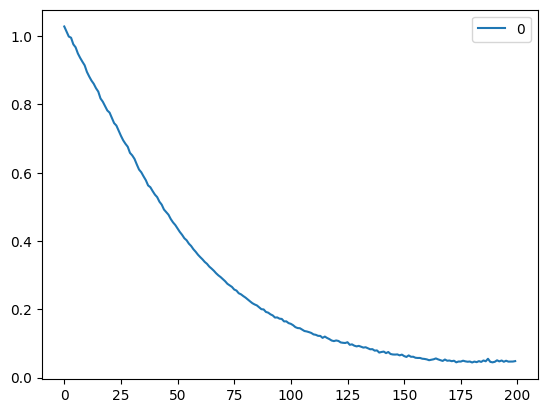

In [692]:
pd.DataFrame(train_loss_ep).plot()

In [693]:
df_norm[-config['seq_len']:,:].shape

(24, 1)

In [694]:
r = df_norm[-config['seq_len']:,:]
print(r)

x = torch.tensor(r[-config['seq_len']:,:]).unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(x.float().to(device))
r = np.append(r, output.squeeze(0).to("cpu").detach().numpy(), axis=0)

[[1.24017878]
 [1.23468834]
 [1.24819261]
 [1.25081851]
 [1.25047747]
 [1.26125364]
 [1.25866188]
 [1.26234492]
 [1.25102312]
 [1.25061391]
 [1.24914746]
 [1.24355482]
 [1.26036696]
 [1.26234492]
 [1.26940391]
 [1.25896878]
 [1.25446732]
 [1.25235303]
 [1.25347845]
 [1.25835497]
 [1.26916528]
 [1.26674398]
 [1.26855137]
 [1.27499665]]


In [695]:
print(r[-24:])

[[1.27675068]
 [1.26622581]
 [1.27474988]
 [1.25845551]
 [1.22837996]
 [1.24714351]
 [1.2729758 ]
 [1.22001886]
 [1.29264283]
 [1.25227976]
 [1.24418032]
 [1.29979551]
 [1.2877301 ]
 [1.28989482]
 [1.25166321]
 [1.28428733]
 [1.28862453]
 [1.32700503]
 [1.29038155]
 [1.33936489]
 [1.24981475]
 [1.29618466]
 [1.31721318]
 [1.28732562]]


<Axes: >

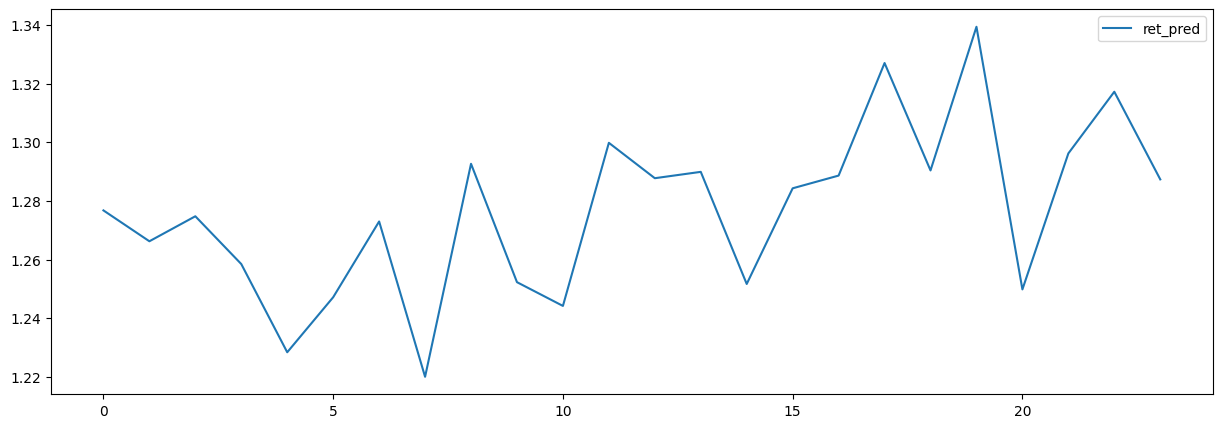

In [696]:
res_df = pd.DataFrame(r[-24:])
res_df.columns = ["ret_pred"]
res_df.plot(figsize=(15,5))

In [697]:
history

,date,Open,High,Low,Close,Adj Close,Volume,Return
0,2019-10-01,297.739990,298.459991,293.000000,293.239990,275.121155,88242400,1.000000
1,2019-10-02,291.500000,291.510010,286.640015,288.059998,270.261139,122539500,0.982335
2,2019-10-03,287.809998,290.450012,284.820007,290.420013,272.475342,85278800,0.990383
3,2019-10-04,291.140015,294.630005,291.079987,294.350006,276.162506,65091200,1.003785
4,2019-10-07,293.470001,295.260010,292.769989,293.079987,274.970917,59610500,0.999454
...,...,...,...,...,...,...,...,...
584,2022-01-25,433.059998,439.720001,427.149994,434.470001,422.840790,167997300,1.481619
585,2022-01-26,440.720001,444.040009,428.859985,433.380005,421.779938,186391100,1.477902
586,2022-01-27,438.260010,441.589996,429.450012,431.239990,419.697235,149878300,1.470604
587,2022-01-28,432.679993,442.000000,427.820007,441.950012,430.120575,164457400,1.507127


In [698]:
his_24d = history[(history['date'] >= '2020-11-26') 
            & (history['date'] <= '2021-01-03')]
len(his_24d)

24

In [699]:
real = history[(history['date'] >= '2021-01-04') 
            & (history['date'] <= '2021-02-07')]
#display(real)
pred = pd.DataFrame()
pred['Return'] = res_df
pred = pred.set_index(real.index)
display(pred)

,Return
317,1.276751
318,1.266226
319,1.274750
320,1.258456
321,1.228380
322,1.247144
323,1.272976
324,1.220019
325,1.292643
326,1.252280


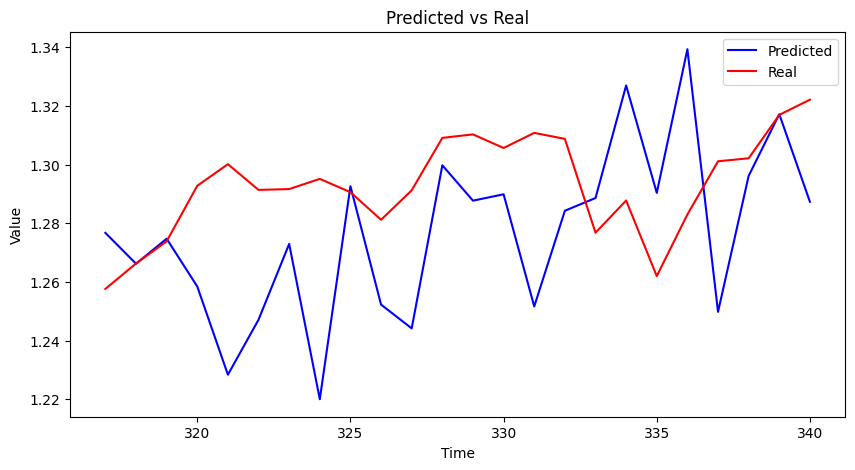

In [700]:
# 假设 pred 和 real 是你的两个时间序列数据

# 创建一个新的图形
plt.figure(figsize=(10, 5))

# 绘制 pred 数据
plt.plot(pred['Return'], label='Predicted', color='blue')

# 绘制 real 数据
plt.plot(real['Return'], label='Real', color='red')

# 添加标题和标签
plt.title('Predicted vs Real')
plt.xlabel('Time')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [701]:
print(pred['Return'].mean())
print(real['Return'].mean())
print(his_24d['Return'].mean())

1.2767953375975292
1.2928716448077378
1.2562562953867988
